# Collaborative Filtering using fastai
---

In [50]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
from fastai.collab import *

In [52]:
import fastai
fastai.__version__

'1.0.48.dev0'

## Load Movielens Data

### Download Data

In [3]:
! touch ~/.fastai/data/ml-100k.zip

In [4]:
! curl 'http://files.grouplens.org/datasets/movielens/ml-100k.zip' --output ~/.fastai/data/ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  62216      0  0:01:19  0:01:19 --:--:-- 82302


In [5]:
! unzip ~/.fastai/data/ml-100k.zip -d ~/.fastai/data/

Archive:  /home/aman/.fastai/data/ml-100k.zip
   creating: /home/aman/.fastai/data/ml-100k/
  inflating: /home/aman/.fastai/data/ml-100k/allbut.pl  
  inflating: /home/aman/.fastai/data/ml-100k/mku.sh  
  inflating: /home/aman/.fastai/data/ml-100k/README  
  inflating: /home/aman/.fastai/data/ml-100k/u.data  
  inflating: /home/aman/.fastai/data/ml-100k/u.genre  
  inflating: /home/aman/.fastai/data/ml-100k/u.info  
  inflating: /home/aman/.fastai/data/ml-100k/u.item  
  inflating: /home/aman/.fastai/data/ml-100k/u.occupation  
  inflating: /home/aman/.fastai/data/ml-100k/u.user  
  inflating: /home/aman/.fastai/data/ml-100k/u1.base  
  inflating: /home/aman/.fastai/data/ml-100k/u1.test  
  inflating: /home/aman/.fastai/data/ml-100k/u2.base  
  inflating: /home/aman/.fastai/data/ml-100k/u2.test  
  inflating: /home/aman/.fastai/data/ml-100k/u3.base  
  inflating: /home/aman/.fastai/data/ml-100k/u3.test  
  inflating: /home/aman/.fastai/data/ml-100k/u4.base  
  inflating: /home/aman/.fa

In [53]:
path = Path('/home/aman/.fastai/data/ml-100k')

In [54]:
path.ls()

[PosixPath('/home/aman/.fastai/data/ml-100k/u.data'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u4.base'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u.info'),
 PosixPath('/home/aman/.fastai/data/ml-100k/README'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u5.base'),
 PosixPath('/home/aman/.fastai/data/ml-100k/ub.base'),
 PosixPath('/home/aman/.fastai/data/ml-100k/ub.test'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u.item'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u2.test'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u3.test'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u.user'),
 PosixPath('/home/aman/.fastai/data/ml-100k/mku.sh'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u4.test'),
 PosixPath('/home/aman/.fastai/data/ml-100k/ua.base'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u3.base'),
 PosixPath('/home/aman/.fastai/data/ml-100k/models'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u1.test'),
 PosixPath('/home/aman/.fastai/data/ml-100k/u1.base'),
 PosixPath('/home

### Read into DataFrame

In [55]:
ratings = pd.read_csv(path/'u.data', sep='\t', header=None, names=['userID', 'itemID','rating', 'timestamp'])
ratings.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [56]:
movies = pd.read_csv(path/'u.item', sep='|', header=None,  encoding='latin-1',names=['itemID', 'title', *[f'col_{i}' for i in range(22)]])
movies.head()

,itemID,title,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [57]:
movies_ratings = ratings.merge(movies[['itemID', 'title']])
movies_ratings.head()

,userID,itemID,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


### Create DataBunch

In [58]:
data = CollabDataBunch.from_df(movies_ratings, valid_pct=0.1,
                               user_name='userID', item_name='title', rating_name='rating')
data.show_batch()

userID,title,target
591,One Flew Over the Cuckoo's Nest (1975),5.0
659,Rebecca (1940),5.0
359,"Fifth Element, The (1997)",4.0
524,Lone Star (1996),5.0
843,Willy Wonka and the Chocolate Factory (1971),2.0


In [59]:
ratings_range = [0,5.5]

## Train Collaborative Filtering Learner

In [60]:
learner = collab_learner(data, n_factors=50, y_range=ratings_range, metrics=accuracy_thresh)

In [61]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1646, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1646, 1)
)

In [62]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


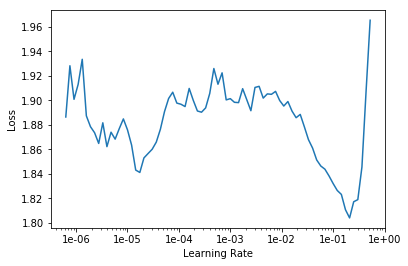

In [63]:
learner.recorder.plot(skip_end=15)

In [65]:
lr =1e-2

In [66]:
learner.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.953867,0.948326,0.061600,00:06
1,0.798419,0.907082,0.061600,00:06
2,0.418705,0.916869,0.061600,00:06


In [67]:
learner.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.642619,1.104277,0.061600,00:06
1,0.562425,1.069876,0.061600,00:07
2,0.285817,1.053941,0.061600,00:07


In [68]:
learner.save('dotprod')

## Interpretation

In [69]:
learner = collab_learner(data, n_factors=50, y_range=ratings_range, metrics=accuracy_thresh)

In [70]:
learner.load('dotprod');

In [71]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1646, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1646, 1)
)

### For Most Rated Movies

In [72]:
movies_ratings.head()

,userID,itemID,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [73]:
g = movies_ratings.groupby('title')['rating'].count()

In [74]:
top_movies = g.sort_values(ascending=False)[:1000]

In [75]:
top_movies[:10]

title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

In [76]:
top_movies[-10:]

title
Waiting to Exhale (1995)               16
Ruling Class, The (1972)               16
Gang Related (1997)                    16
Exit to Eden (1994)                    16
Bad Taste (1987)                       16
Selena (1997)                          16
In the Bleak Midwinter (1995)          16
Party Girl (1995)                      16
Highlander III: The Sorcerer (1994)    16
Bastard Out of Carolina (1996)         16
Name: rating, dtype: int64

### Movie Bias

In [81]:
bias = learner.bias(top_movies.index)
bias.shape

torch.Size([1000])

In [88]:
mean_ratings = movies_ratings.groupby('title')['rating'].mean()
mean_ratings.head()

title
'Til There Was You (1997)    2.333333
1-900 (1994)                 2.600000
101 Dalmatians (1996)        2.908257
12 Angry Men (1957)          4.344000
187 (1997)                   3.024390
Name: rating, dtype: float64

In [98]:
movie_bias = [(i,b, mean_ratings[i]) for i,b in zip(top_movies.index, bias)]
movie_bias[:5]

[('Star Wars (1977)', tensor(1.0770), 4.3584905660377355),
 ('Contact (1997)', tensor(0.6974), 3.8035363457760316),
 ('Fargo (1996)', tensor(0.7432), 4.155511811023622),
 ('Return of the Jedi (1983)', tensor(0.7439), 4.007889546351085),
 ('Liar Liar (1997)', tensor(0.0682), 3.156701030927835)]

In [99]:
mean_ratings['Star Wars (1977)'], bias[0]

(4.3584905660377355, tensor(1.0770))

In [107]:
sorted(movie_bias, key=lambda x:x[1], reverse=True)[:10]

[("Schindler's List (1993)", tensor(1.2091), 4.466442953020135),
 ('Titanic (1997)', tensor(1.1451), 4.2457142857142856),
 ('Casablanca (1942)', tensor(1.1326), 4.45679012345679),
 ('Star Wars (1977)', tensor(1.0770), 4.3584905660377355),
 ('Rear Window (1954)', tensor(1.0605), 4.3875598086124405),
 ('Shawshank Redemption, The (1994)', tensor(1.0540), 4.445229681978798),
 ('Wrong Trousers, The (1993)', tensor(1.0519), 4.466101694915254),
 ('Usual Suspects, The (1995)', tensor(1.0316), 4.385767790262173),
 ('Good Will Hunting (1997)', tensor(1.0178), 4.262626262626263),
 ('Close Shave, A (1995)', tensor(1.0045), 4.491071428571429)]

In [106]:
sorted(movie_bias, key=lambda x:x[1], reverse=False)[:10]

[('Lawnmower Man 2: Beyond Cyberspace (1996)',
  tensor(-0.8612),
  1.7142857142857142),
 ('Children of the Corn: The Gathering (1996)',
  tensor(-0.7255),
  1.3157894736842106),
 ('Mortal Kombat: Annihilation (1997)', tensor(-0.7210), 1.9534883720930232),
 ('Barb Wire (1996)', tensor(-0.6732), 1.9333333333333333),
 ('Home Alone 3 (1997)', tensor(-0.6701), 1.894736842105263),
 ('Showgirls (1995)', tensor(-0.6645), 1.9565217391304348),
 ('Hellraiser: Bloodline (1996)', tensor(-0.6588), 2.0),
 ('Free Willy 3: The Rescue (1997)', tensor(-0.6392), 1.7407407407407407),
 ('Crow: City of Angels, The (1996)', tensor(-0.6374), 1.9487179487179487),
 ('Leave It to Beaver (1997)', tensor(-0.6243), 1.8409090909090908)]

### Movie Weights

In [111]:
weights = learner.weight(top_movies.index)
weights.shape

torch.Size([1000, 50])

In [116]:
(fac1, fac2) = weights.pca(k=2).t()

In [119]:
movie_weigts = [(i, f1, f2, mean_ratings[i]) for i,f1,f2 in zip(top_movies.index, fac1, fac2)]

**Factor 1 representation**

In [136]:
print(*sorted(movie_weigts, key=lambda x:x[1], reverse=True)[:10], sep='\n')

('Down by Law (1986)', tensor(1.5418), tensor(-0.3640), 3.7714285714285714)
('Bad Taste (1987)', tensor(1.3861), tensor(-0.1052), 3.375)
('Chinatown (1974)', tensor(1.2782), tensor(0.2859), 4.136054421768708)
('Delicatessen (1991)', tensor(1.2722), tensor(0.2930), 3.876923076923077)
('Big Sleep, The (1946)', tensor(1.2355), tensor(-0.3216), 4.027397260273973)
('Ghost in the Shell (Kokaku kidotai) (1995)', tensor(1.2190), tensor(0.3682), 3.6538461538461537)
('Old Man and the Sea, The (1958)', tensor(1.1920), tensor(-0.5717), 3.34375)
('8 1/2 (1963)', tensor(1.1543), tensor(0.4690), 3.8157894736842106)
('Thin Man, The (1934)', tensor(1.1413), tensor(-0.0937), 4.15)
('Touch of Evil (1958)', tensor(1.1242), tensor(-0.0892), 3.911764705882353)


In [137]:
print(*sorted(movie_weigts, key=lambda x:x[1], reverse=False)[:10], sep='\n')

('Shadow Conspiracy (1997)', tensor(-1.3907), tensor(0.3918), 2.8636363636363638)
('Beverly Hills Cop III (1994)', tensor(-1.3629), tensor(0.6043), 2.392857142857143)
('Beverly Hillbillies, The (1993)', tensor(-1.3618), tensor(0.2698), 2.25)
('Turbulence (1997)', tensor(-1.3186), tensor(-0.2513), 2.5652173913043477)
('Batman & Robin (1997)', tensor(-1.2267), tensor(0.2347), 2.4516129032258065)
('Bio-Dome (1996)', tensor(-1.2169), tensor(0.7667), 1.903225806451613)
('Batman Forever (1995)', tensor(-1.1698), tensor(0.5102), 2.6666666666666665)
('Net, The (1995)', tensor(-1.1253), tensor(0.0352), 3.0083333333333333)
('D3: The Mighty Ducks (1996)', tensor(-1.1148), tensor(0.0227), 2.5789473684210527)
('Tales from the Hood (1995)', tensor(-1.0973), tensor(0.4494), 2.037037037037037)


**Factor 2 representation**

In [138]:
print(*sorted(movie_weigts, key=lambda x:x[2], reverse=True)[:10], sep='\n')

('Beavis and Butt-head Do America (1996)', tensor(-0.1013), tensor(1.2599), 2.7884615384615383)
('Dracula: Dead and Loving It (1995)', tensor(-0.6490), tensor(1.0581), 2.28)
('Paradise Lost: The Child Murders at Robin Hood Hills (1996)', tensor(0.7307), tensor(0.9879), 4.05)
('Romeo Is Bleeding (1993)', tensor(0.2388), tensor(0.9754), 3.0)
('Trainspotting (1996)', tensor(0.8858), tensor(0.9611), 3.884)
('Blues Brothers 2000 (1998)', tensor(0.1231), tensor(0.9525), 2.8214285714285716)
('Lost Highway (1997)', tensor(0.2773), tensor(0.9509), 3.136)
('Hellraiser: Bloodline (1996)', tensor(-0.3419), tensor(0.9255), 2.0)
('Crow: City of Angels, The (1996)', tensor(-0.8119), tensor(0.9187), 1.9487179487179487)
('Evil Dead II (1987)', tensor(0.4679), tensor(0.9025), 3.5168539325842696)


In [139]:
print(*sorted(movie_weigts, key=lambda x:x[2], reverse=False)[:10], sep='\n')

('Braveheart (1995)', tensor(-0.1758), tensor(-1.2507), 4.151515151515151)
("It's a Wonderful Life (1946)", tensor(0.1448), tensor(-1.0530), 4.121212121212121)
('Sleepless in Seattle (1993)', tensor(-0.1769), tensor(-1.0450), 3.539906103286385)
('Miracle on 34th Street (1994)', tensor(0.0406), tensor(-0.9652), 3.722772277227723)
('Amateur (1994)', tensor(0.5791), tensor(-0.9586), 3.1666666666666665)
('American President, The (1995)', tensor(-0.6015), tensor(-0.9311), 3.6280487804878048)
('Dave (1993)', tensor(-0.2710), tensor(-0.9055), 3.65)
('Dirty Dancing (1987)', tensor(-0.6857), tensor(-0.9039), 3.1020408163265305)
('Meet John Doe (1941)', tensor(0.8002), tensor(-0.8891), 3.92)
('Now and Then (1995)', tensor(-0.4483), tensor(-0.8846), 3.4583333333333335)


**PCA Visualization**

In [160]:
idxs = np.random.choice(len(top_movies), size=50, replace=False)

In [164]:
x = fac1[idxs]
y = fac2[idxs]
movie_titles = top_movies[idxs]

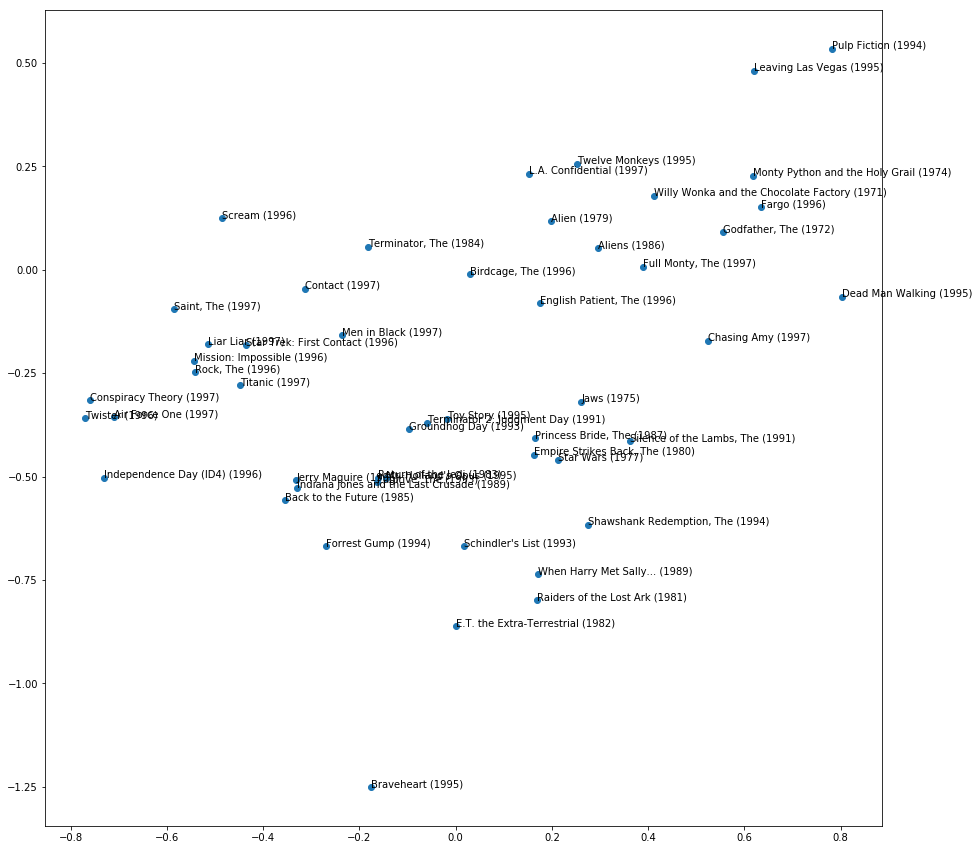

In [165]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x, y)
for title, x_i, y_i in zip(movie_titles.index, x, y):
    ax.text(x_i,y_i,title)